In [83]:
# imports 
import os
import pyrugga as pgr

import matplotlib.pyplot as plt
#import seaborn as sns

import pandas as pd
#import modin.pandas as pd

import numpy as np

import scipy as sp

import seaborn as sns

plt.style.context('tableau-colorblind10')

%matplotlib inline


In [5]:
# define out zones
def Zones( x ): 
    x = 10 * round( x / 10) 
    if x > 95:
        x = 95
    if x < 5:
        x = 5
    return x

In [6]:
# scan folder and load files into dataframe
FILES_LOC = 'Data/'

import os
def scan_files(path):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    xml_files = []
    for f in files:
        if '.xml' in f.lower() :
            xml_files.append(f)

    return xml_files

matches = []
for fn in scan_files(FILES_LOC):
    #print(FILES_LOC + fn)
    matches.append(pgr.Match(FILES_LOC + fn,zones=Zones))

In [7]:
#Check stats
dates = []
for match in matches:
    dates.append(match.summary['fixture_date'][0])

print("Number of Matches : %s" % str(len(matches)))
print("First game : " + str(pd.to_datetime(pd.DataFrame(dates,columns=['dte'])['dte']).min()))
print("Last game : " + str(pd.to_datetime(pd.DataFrame(dates,columns=['dte'])['dte']).max()))

Number of Matches : 248
First game : 2017-01-09 00:00:00
Last game : 2019-12-04 00:00:00


In [8]:
df = pd.DataFrame()
for match in matches:
    df = pd.concat([df,match.summary])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


0.3893129770992367

In [44]:
results = pd.DataFrame()
for match in matches:
    match.summary['territory'] = match.getTerritoryMetric().iloc[0,1]
    results = pd.concat([results,match.summary])
    

results['win'] = results['home_score'] - results['away_score']

In [95]:
# extract the data we require
features = [
    'fixture_code',
    'team_name',
    'start_event',
    'end_event',
    'points',
    'length',
    'start',
    'x_coord',
    'x_coord_end',
    'y_coord',
    'y_coord_end',
    'pick_and_go',
    'one_out_drive',
    'penalty_try',
    'lineout_throw',
    'lineout',
    'maul',
    'phases',
    'pass',
    'complete_pass',
    'incomplete_pass',
    'goal_missed',     
    'throw_front',
    'throw_middle',
    'throw_back',
    'throw_15m_plus',
    'tackle',
    'missed_tackle',    
    'lost_in_ruck_or_maul',
    'sack',
    'jackal',
    'start_set_lineout_steal',
    'yellow_card',
    'red_card',
    'advantage',
    'pen_conceded',
    'penalty_won'
]

df = pd.DataFrame()
for match in matches:
    match.timeline['x_coord'] = (match.timeline['x_coord']*1.0).apply(match._Zones)
    match.timeline['y_coord'] = (match.timeline['y_coord']*1.0).apply(match._Zones)
    
    match.timeline['x_coord_end'] = (match.timeline['x_coord_end']*1.0).apply(match._Zones)
    match.timeline['y_coord_end'] = (match.timeline['y_coord_end']*1.0).apply(match._Zones)
    
    match.timeline['fixture_code'] = match.summary.fixture_code[0]

    
    try:
        df = pd.concat([df, match.timeline[features]], sort=False)
    except:
        df = match.timeline[features]

In [96]:
metrics = df.groupby(['fixture_code','team_name'])[features[11:]].sum().reset_index()

In [97]:
away_df = pd.merge(metrics, results, left_on=['fixture_code','team_name'], right_on=['fixture_code','awayteam'])
home_df = pd.merge(metrics, results, left_on=['fixture_code','team_name'], right_on=['fixture_code','hometeam'])
away_df['win'] = away_df['win']*-1
away_df['territory'] = 1 - away_df['territory']

df = pd.concat([away_df,home_df]).sort_values(by='fixture_code')

In [98]:
del df['away_score']
del df['home_score']
del df['hometeam']
del df['awayteam']
del df['fx_week']
del df['fixture_date']
del df['ref_name']
del df['ref_id']

In [99]:
var_list = list(df.columns)[2:-1]

In [100]:
len(df[var_list])

496

In [101]:
len(df['win'])

496

In [108]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

import xgboost as xgb


X = df[var_list].values
y = df['win'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train, missing=0)
dval = xgb.DMatrix(X_test,label=y_test)
evallist = [(dval,'eval'),(dtrain,'train')]

param = { 
    'silent':1, 
    'objective':'reg:squarederror', 
    'booster':'gbtree', 
    'eval_metric' : 'rmse',
    'rate_drop' :0.10,
    'max_depth' : 2,
}

num_round = 100
bts = xgb.train(param, dtrain, num_round,evallist,early_stopping_rounds=5,verbose_eval=False)

test = pd.DataFrame()
train = pd.DataFrame()

dtrain = xgb.DMatrix(X, label=y, missing=0)
dval = xgb.DMatrix(X_test,label=y_test)

train['trend'] = y
test['trend'] = y_test

test['pred'] = bts.predict(dval)
train['pred'] = bts.predict(dtrain)

In [109]:
df['pred'] = bts.predict(xgb.DMatrix(X, label=y, missing=0))

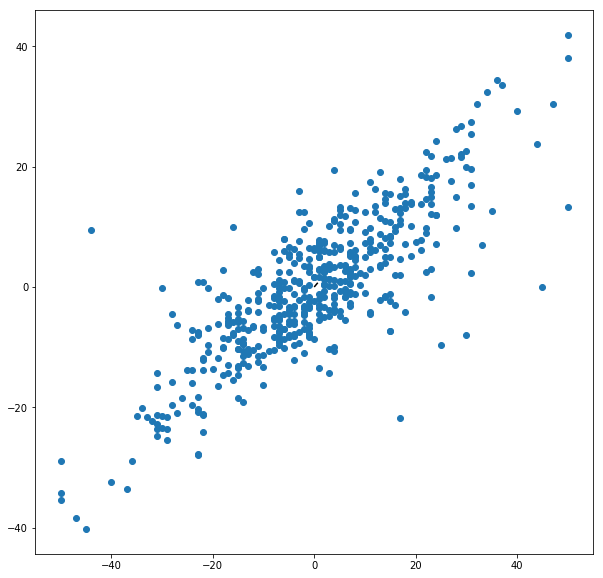

In [111]:
# Click to expand
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(df['win'],df['pred'])


ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

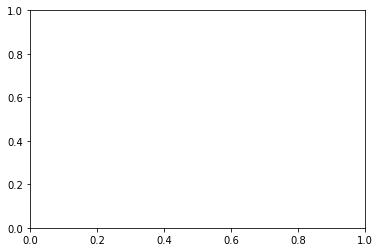

In [114]:
from xgboost import plot_tree

plot_tree(bts)
plt.show()

In [115]:
from xgboost import plot_importance


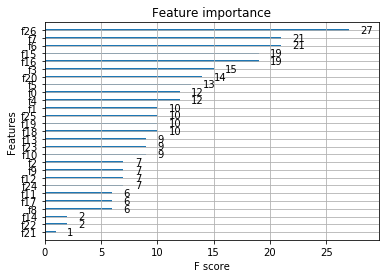

In [119]:
plot_importance(bts)

In [121]:
bts.get_fscore()

{'f16': 19,
 'f10': 9,
 'f4': 12,
 'f3': 15,
 'f6': 21,
 'f8': 6,
 'f5': 13,
 'f24': 7,
 'f18': 10,
 'f0': 12,
 'f20': 14,
 'f19': 10,
 'f23': 9,
 'f15': 19,
 'f22': 2,
 'f12': 7,
 'f26': 27,
 'f7': 21,
 'f9': 7,
 'f25': 10,
 'f2': 7,
 'f1': 10,
 'f17': 6,
 'f13': 9,
 'f14': 2,
 'f11': 6,
 'f21': 1}

In [132]:
var_list[20]

'start_set_lineout_steal'